In [1]:
# 011 Sinthetic data 1000 epoch normal and real attack data

# Autoencoders for non-supervised intrusion detection

Training : Real Data <br>
Testing  : Real Data <br>
1000 epochs

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-09-23 23:10:53.363068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 23:10:53.363090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [4]:
#path = './data/Zero_Day/'
path = './new_data/'
#path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_normal = path +'normal.csv'
path_attack = path + 'attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
attack_df = pd.read_csv(path_attack)  

normal_df['marker'] = normal_df.apply(label_marker, axis=1)
attack_df['marker'] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df['marker'].to_numpy() 
attack_label = attack_df['marker'].to_numpy() 

print(len(normal_label))
print(len(attack_label))

22714
55663


In [5]:
# Delete marker column 
normal_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 128)
attack shape (55663, 128)


In [7]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

In [8]:
attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [9]:
#labels = combine_labels
#norm_samples = df_scaled[labels == 0]  # normal data
#attack_samples = df_scaled[labels == 1]  # attack data

#norm_labels = labels[labels == 0]
#attack_labels = labels[labels == 1]

In [10]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(55663, 128)
(22714, 128)


In [11]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [12]:
X_train.shape
print(' X_test normal shape',X_test_norm.shape, '\n', 
      'X_test attack shape', X_test_attack.shape, '\n',
      'X_train normal shape', X_train.shape, '\n',
      'X_test shape', X_test.shape)

 X_test normal shape (4543, 128) 
 X_test attack shape (4543, 128) 
 X_train normal shape (18171, 128) 
 X_test shape (9086, 128)


In [13]:
# we use RMSE as reconstruction error (can use MAE as well)
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [14]:
# The reparameterization trick for the autoencoder

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2) 
latent_dim = int(original_dim / 3) 

#intermediate_dim = 256
#latent_dim = 128
print(' original_dim : ', original_dim,'\n',
      'intermediate_dim : ', intermediate_dim, '\n', 
      'latent_dim : ', latent_dim)

 original_dim :  128 
 intermediate_dim :  64 
 latent_dim :  42


In [16]:
# enconder >< decoder
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 42)           2730        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 42)           2730        ['dense[0][0]']                  
                                                                                            

In [17]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 42)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                2752      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
Total params: 11,072
Trainable params: 11,072
Non-trainable params: 0
_________________________________________________________________


In [18]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [19]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [20]:
# Training autoencoder
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=1000,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128)]             0         
                                                                 
 encoder (Functional)        (None, 42)                13716     
                                                                 
 decoder (Functional)        (None, 128)               11072     
                                                                 
Total params: 24,788
Trainable params: 24,788
Non-trainable params: 0
_________________________________________________________________
Train on 18171 samples
Epoch 1/1000


2022-09-23 23:10:57.582097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 23:10:57.582856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 23:10:57.582964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-23 23:10:57.583057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-23 23:10:57.585505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

18171/18171 [==============================] - 1s 59us/sample - loss: 255.6467
Epoch 2/1000
18171/18171 [==============================] - 1s 42us/sample - loss: 85.0072
Epoch 3/1000
18171/18171 [==============================] - 1s 44us/sample - loss: 68.0772
Epoch 4/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 61.1742
Epoch 5/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 54.5092
Epoch 6/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 48.8002
Epoch 7/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 44.4181
Epoch 8/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 41.0343
Epoch 9/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 38.3563
Epoch 10/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 36.4900
Epoch 11/1000
18171/18171 [==============================] - 1s 42us/sample - loss: 34.9576
Epoch 12/

18171/18171 [==============================] - 1s 43us/sample - loss: 19.0527
Epoch 91/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 18.9532
Epoch 92/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 18.9298
Epoch 93/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 18.8885
Epoch 94/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 18.8645
Epoch 95/1000
18171/18171 [==============================] - 1s 44us/sample - loss: 18.7055
Epoch 96/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 18.6581
Epoch 97/1000
18171/18171 [==============================] - 1s 45us/sample - loss: 18.5929
Epoch 98/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 18.5357
Epoch 99/1000
18171/18171 [==============================] - 1s 44us/sample - loss: 18.5017
Epoch 100/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 18.4093
E

18171/18171 [==============================] - 1s 46us/sample - loss: 15.5033
Epoch 179/1000
18171/18171 [==============================] - 1s 47us/sample - loss: 15.5201
Epoch 180/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 15.5142
Epoch 181/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 15.4391
Epoch 182/1000
18171/18171 [==============================] - 1s 47us/sample - loss: 15.4920
Epoch 183/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 15.4282
Epoch 184/1000
18171/18171 [==============================] - 1s 44us/sample - loss: 15.4386
Epoch 185/1000
18171/18171 [==============================] - 1s 41us/sample - loss: 15.3574
Epoch 186/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 15.3870
Epoch 187/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 15.3938
Epoch 188/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 

18171/18171 [==============================] - 1s 45us/sample - loss: 14.4805
Epoch 267/1000
18171/18171 [==============================] - 1s 53us/sample - loss: 14.5219
Epoch 268/1000
18171/18171 [==============================] - 1s 52us/sample - loss: 14.4885
Epoch 269/1000
18171/18171 [==============================] - 1s 48us/sample - loss: 14.4635
Epoch 270/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 14.4487
Epoch 271/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 14.4822
Epoch 272/1000
18171/18171 [==============================] - 1s 41us/sample - loss: 14.4634
Epoch 273/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 14.4434
Epoch 274/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 14.4559
Epoch 275/1000
18171/18171 [==============================] - 1s 56us/sample - loss: 14.4229
Epoch 276/1000
18171/18171 [==============================] - 1s 54us/sample - loss: 

18171/18171 [==============================] - 1s 51us/sample - loss: 14.0345
Epoch 355/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 14.0870
Epoch 356/1000
18171/18171 [==============================] - 1s 57us/sample - loss: 14.0381
Epoch 357/1000
18171/18171 [==============================] - 1s 51us/sample - loss: 14.0645
Epoch 358/1000
18171/18171 [==============================] - 1s 52us/sample - loss: 14.0558
Epoch 359/1000
18171/18171 [==============================] - 1s 47us/sample - loss: 14.0632
Epoch 360/1000
18171/18171 [==============================] - 1s 41us/sample - loss: 13.9895
Epoch 361/1000
18171/18171 [==============================] - 1s 48us/sample - loss: 14.0651
Epoch 362/1000
18171/18171 [==============================] - 1s 41us/sample - loss: 14.0374
Epoch 363/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 14.0176
Epoch 364/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 

18171/18171 [==============================] - 1s 43us/sample - loss: 13.8904
Epoch 443/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 13.8782
Epoch 444/1000
18171/18171 [==============================] - 1s 42us/sample - loss: 13.8687
Epoch 445/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.8830
Epoch 446/1000
18171/18171 [==============================] - 1s 41us/sample - loss: 13.9184
Epoch 447/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 13.8719
Epoch 448/1000
18171/18171 [==============================] - 1s 43us/sample - loss: 13.8906
Epoch 449/1000
18171/18171 [==============================] - 1s 47us/sample - loss: 13.7952
Epoch 450/1000
18171/18171 [==============================] - 1s 41us/sample - loss: 13.9132
Epoch 451/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.8728
Epoch 452/1000
18171/18171 [==============================] - 1s 59us/sample - loss: 

18171/18171 [==============================] - 1s 46us/sample - loss: 13.7718
Epoch 531/1000
18171/18171 [==============================] - 1s 45us/sample - loss: 13.7890
Epoch 532/1000
18171/18171 [==============================] - 1s 47us/sample - loss: 13.7586
Epoch 533/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.7964
Epoch 534/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.8115
Epoch 535/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.8060
Epoch 536/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.8207
Epoch 537/1000
18171/18171 [==============================] - 1s 48us/sample - loss: 13.7795
Epoch 538/1000
18171/18171 [==============================] - 1s 40us/sample - loss: 13.7810
Epoch 539/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.8037
Epoch 540/1000
18171/18171 [==============================] - 1s 51us/sample - loss: 

18171/18171 [==============================] - 1s 46us/sample - loss: 13.5339
Epoch 619/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.6074
Epoch 620/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 13.5598
Epoch 621/1000
18171/18171 [==============================] - 1s 55us/sample - loss: 13.5205
Epoch 622/1000
18171/18171 [==============================] - 1s 53us/sample - loss: 13.5452
Epoch 623/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.5703
Epoch 624/1000
18171/18171 [==============================] - 1s 51us/sample - loss: 13.5806
Epoch 625/1000
18171/18171 [==============================] - 1s 52us/sample - loss: 13.5708
Epoch 626/1000
18171/18171 [==============================] - 1s 52us/sample - loss: 13.5963
Epoch 627/1000
18171/18171 [==============================] - 1s 53us/sample - loss: 13.5975
Epoch 628/1000
18171/18171 [==============================] - 1s 52us/sample - loss: 

18171/18171 [==============================] - 2s 101us/sample - loss: 13.4835
Epoch 707/1000
18171/18171 [==============================] - 1s 80us/sample - loss: 13.5001
Epoch 708/1000
18171/18171 [==============================] - 1s 67us/sample - loss: 13.4984
Epoch 709/1000
18171/18171 [==============================] - 1s 70us/sample - loss: 13.4812
Epoch 710/1000
18171/18171 [==============================] - 2s 99us/sample - loss: 13.5370
Epoch 711/1000
18171/18171 [==============================] - 1s 76us/sample - loss: 13.5034
Epoch 712/1000
18171/18171 [==============================] - 1s 65us/sample - loss: 13.5147
Epoch 713/1000
18171/18171 [==============================] - 1s 75us/sample - loss: 13.4854
Epoch 714/1000
18171/18171 [==============================] - 1s 60us/sample - loss: 13.5041
Epoch 715/1000
18171/18171 [==============================] - 1s 62us/sample - loss: 13.5089
Epoch 716/1000
18171/18171 [==============================] - 2s 86us/sample - loss:

18171/18171 [==============================] - 1s 46us/sample - loss: 13.5393
Epoch 795/1000
18171/18171 [==============================] - 1s 45us/sample - loss: 13.4256
Epoch 796/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.4186
Epoch 797/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.4907
Epoch 798/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.4494
Epoch 799/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.4801
Epoch 800/1000
18171/18171 [==============================] - 1s 45us/sample - loss: 13.5046
Epoch 801/1000
18171/18171 [==============================] - 1s 45us/sample - loss: 13.4471
Epoch 802/1000
18171/18171 [==============================] - 1s 46us/sample - loss: 13.4718
Epoch 803/1000
18171/18171 [==============================] - 1s 47us/sample - loss: 13.4548
Epoch 804/1000
18171/18171 [==============================] - 1s 48us/sample - loss: 

18171/18171 [==============================] - 1s 50us/sample - loss: 13.3272
Epoch 883/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3761
Epoch 884/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3780
Epoch 885/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3829
Epoch 886/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3674
Epoch 887/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3878
Epoch 888/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 13.3605
Epoch 889/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3508
Epoch 890/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.4163
Epoch 891/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.4101
Epoch 892/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 

18171/18171 [==============================] - 1s 50us/sample - loss: 13.3784
Epoch 971/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.4141
Epoch 972/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3451
Epoch 973/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.4206
Epoch 974/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 13.2771
Epoch 975/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.4261
Epoch 976/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 13.3324
Epoch 977/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3255
Epoch 978/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 13.3843
Epoch 979/1000
18171/18171 [==============================] - 1s 49us/sample - loss: 13.3770
Epoch 980/1000
18171/18171 [==============================] - 1s 50us/sample - loss: 

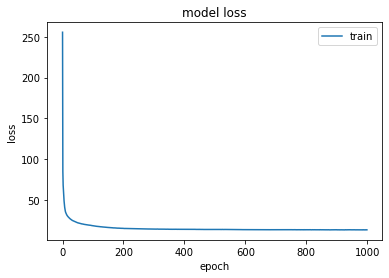

In [21]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [22]:
# Prediction of training vector
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [23]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error \
      {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.99)
print('error threshold >>>', error_thresh)

Avg error 0.01890242787452733
median error       0.016335392852056457
99Q: 0.07004160205418464
error threshold >>> 0.07004160205418464


In [24]:
# application of error threshold in test vector
# A vector of anomalies is created with the points that go over the threshold

X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

total length vector anomalies :  9086
Number of anomalies :  4378
total length of y_test vector 9086
total lenght of attacks in y_test vector 4543


In [25]:
# Sklearn classification report
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      4543
         1.0       0.98      0.95      0.96      4543

    accuracy                           0.96      9086
   macro avg       0.96      0.96      0.96      9086
weighted avg       0.96      0.96      0.96      9086



In [26]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = encoder.predict(X_test)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [27]:
# PCA transformation to observe variance in 2 components

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=123, svd_solver='arpack')
X_transform = pca.fit_transform(X_pred2)

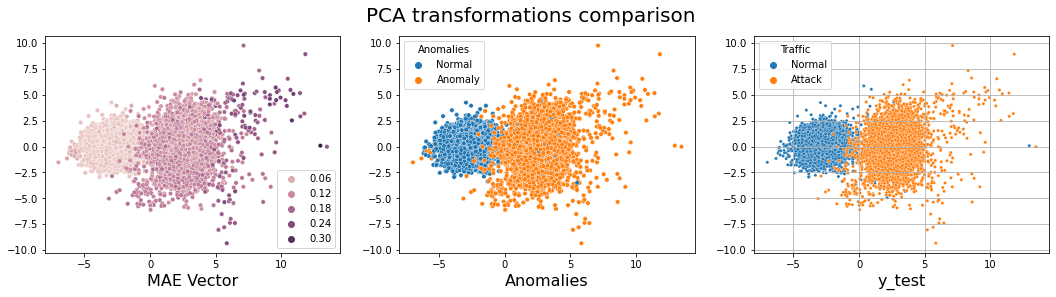

In [28]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Normal', 'Anomaly'], title='Anomalies')
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Normal', 'Attack'], title='Traffic')
plt.grid()
plt.show()

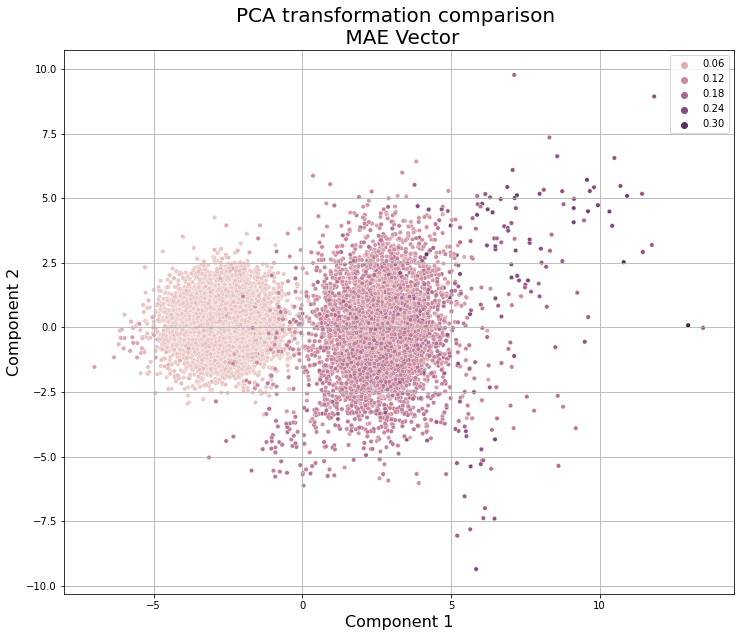

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n MAE Vector',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

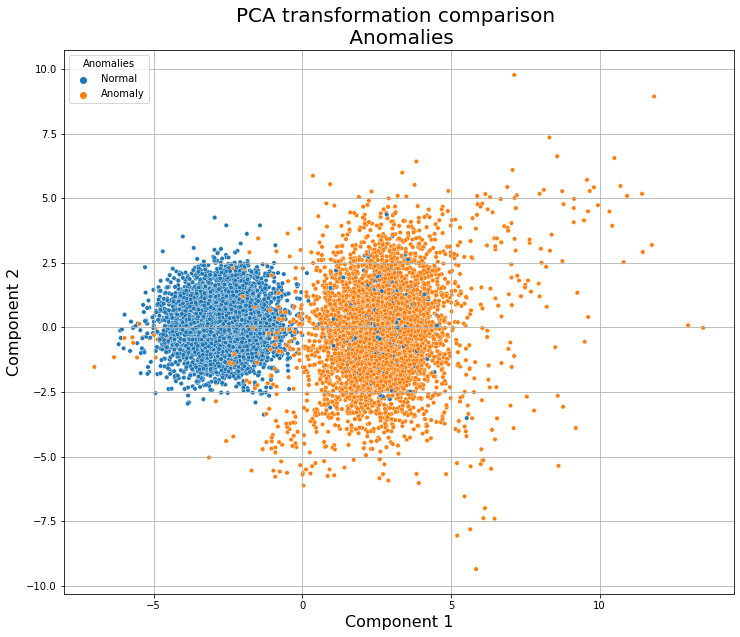

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n Anomalies',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Anomaly'], title='Anomalies')
plt.grid()
plt.show()

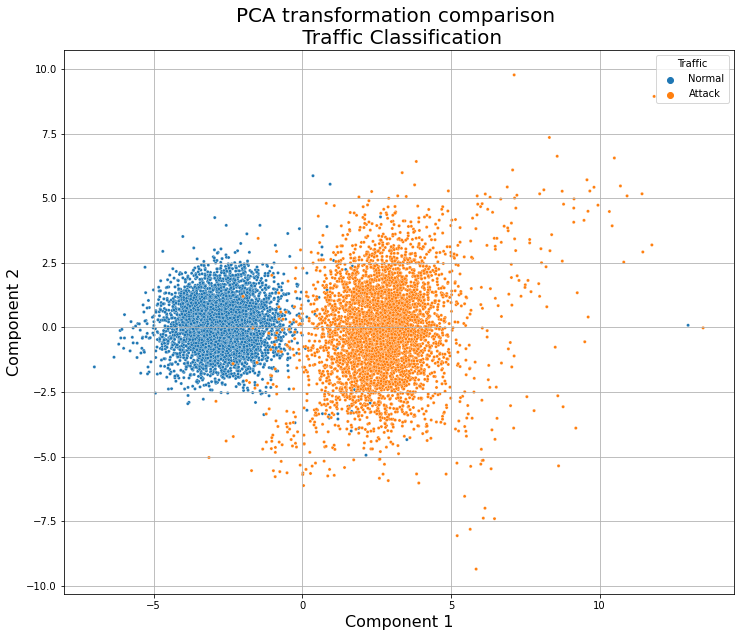

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n Traffic Classification',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic')
plt.grid()
plt.show()

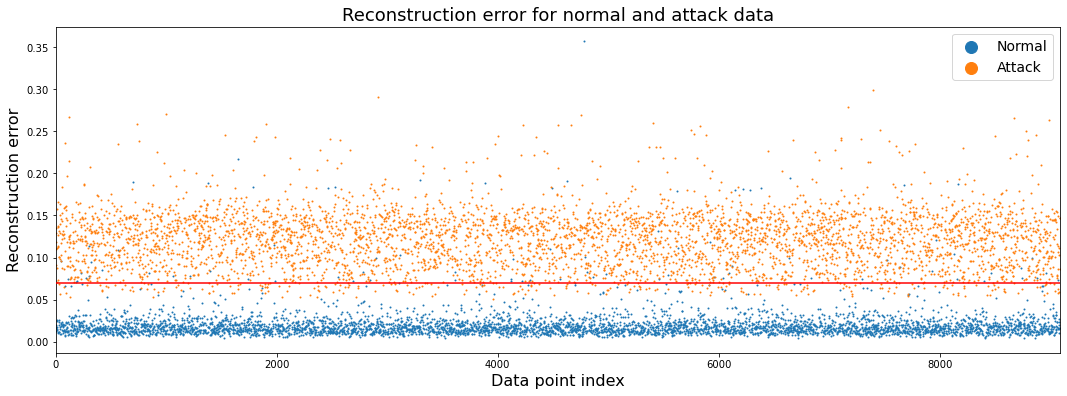

In [32]:
# Reconstruction figure
plt.rc('legend',fontsize=14)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1, linestyle='',
            label= "Attack" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
plt.xlim(0,error_df.shape[0])
# leg = ax.legend()
# leg.set_title('Traffic',prop={'size':14})
plt.legend(legend_label, ['Normal', 'Attack'], prop={'size': 14}, 
          loc="upper right", markerscale=2., scatterpoints=1)
plt.title("Reconstruction error for normal and attack data", size=18)
plt.ylabel("Reconstruction error", size=16)
plt.xlabel("Data point index", size = 16)
plt.show()

In [33]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (4543,) 
 Normal_error shape (4543,)


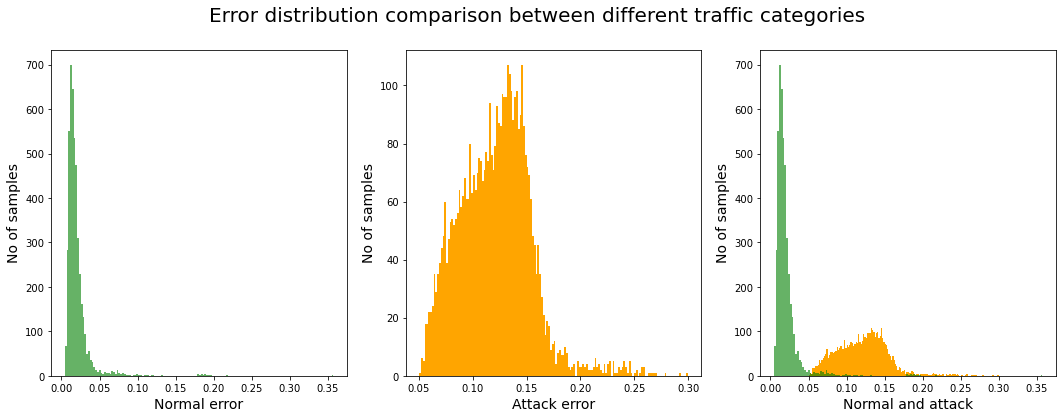

In [34]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

### 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9086 samples in 0.004s...
[t-SNE] Computed neighbors for 9086 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9086
[t-SNE] Computed conditional probabilities for sample 2000 / 9086
[t-SNE] Computed conditional probabilities for sample 3000 / 9086
[t-SNE] Computed conditional probabilities for sample 4000 / 9086
[t-SNE] Computed conditional probabilities for sample 5000 / 9086
[t-SNE] Computed conditional probabilities for sample 6000 / 9086
[t-SNE] Computed conditional probabilities for sample 7000 / 9086
[t-SNE] Computed conditional probabilities for sample 8000 / 9086
[t-SNE] Computed conditional probabilities for sample 9000 / 9086
[t-SNE] Computed conditional probabilities for sample 9086 / 9086
[t-SNE] Mean sigma: 0.130869
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.893204
[t-SNE] KL divergence after 300 iterations: 2.040159


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

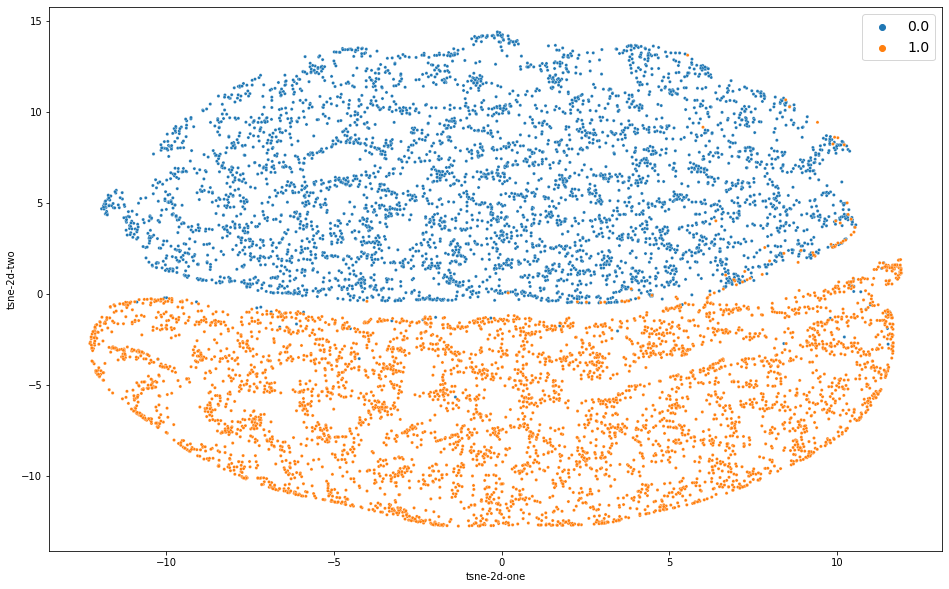

In [35]:
# Analisis latent space with t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_transform)

df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two']) 

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_test,
    data=df_subset,
    s = 10
)

In [36]:
'tsne-2d-two'

'tsne-2d-two'